In [1]:

 
# !cp kaggle.json ~/.kaggle/

In [2]:
# !kaggle datasets download -d zusmani/pakistan-temperature

In [3]:
# !unzip pakistan-temperature.zip

In [4]:
# !rm pakistan-temperature.zip

In [35]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [1]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
tmp =pd.read_csv('Tempreture_1901_2016_Pakistan.csv')

In [2]:
tmp.columns=['temp','year','month']

In [3]:
from matplotlib import style

style.available
# returns:
['bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark-palette',
 'seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'seaborn',
 'Solarize_Light2',
 '_classic_test']
style.use('seaborn-whitegrid')
#font color style



<AxesSubplot:xlabel='year'>

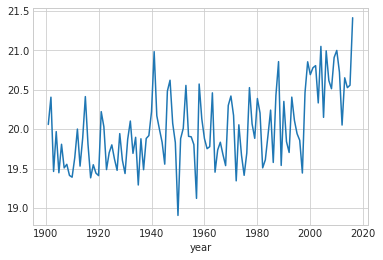

In [4]:
temp=tmp.groupby('year')['temp'].mean()
temp.plot()

In [5]:
tmp.index=pd.to_datetime(tmp['year'].astype(str)  + tmp['month'], format='%Y%B')

In [6]:
tmp.index=tmp.index + pd.offsets.MonthEnd()
tmp

,temp,year,month
1901-01-31,7.72768,1901,January
1901-02-28,8.93600,1901,February
1901-03-31,16.96320,1901,March
1901-04-30,21.27410,1901,April
1901-05-31,26.04970,1901,May
...,...,...,...
2016-08-31,27.63320,2016,August
2016-09-30,26.71790,2016,September
2016-10-31,22.39820,2016,October
2016-11-30,15.76720,2016,November


In [7]:
tmp = tmp.drop(columns=['year', 'month'])

<AxesSubplot:>

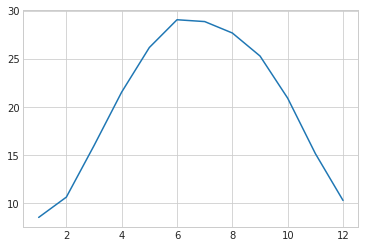

In [8]:
temp=tmp.groupby(tmp.index.month)['temp'].mean()
temp.plot()

Trend

<AxesSubplot:>

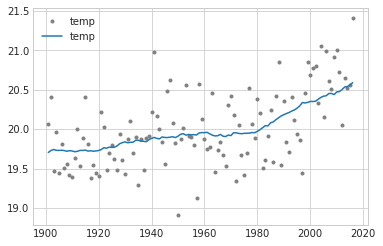

In [13]:
avg_tmp=tmp.groupby(tmp.index.year).mean()
moving_avg=avg_tmp.rolling(
    window=40, center=True, 
    min_periods=3).mean()

ax = avg_tmp.plot(style=".", color="0.5")
moving_avg.plot(ax=ax)

In [15]:
#decomposition

decomp = seasonal_decompose(avg_tmp['temp'], period=30, model='additive', extrapolate_trend='freq')
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True, figsize=(22,10))
ax[0,0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0,0], legend=False, color='dodgerblue')
ax[0,1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[0,1],legend=False, color='dodgerblue')

ax[1,0].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[1,0],legend=False, color='dodgerblue')

ax[1,1].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[1,1],legend=False, color='dodgerblue')

NameError: name 'avg_tmp' is not defined

<AxesSubplot:title={'center':'Noise'}>

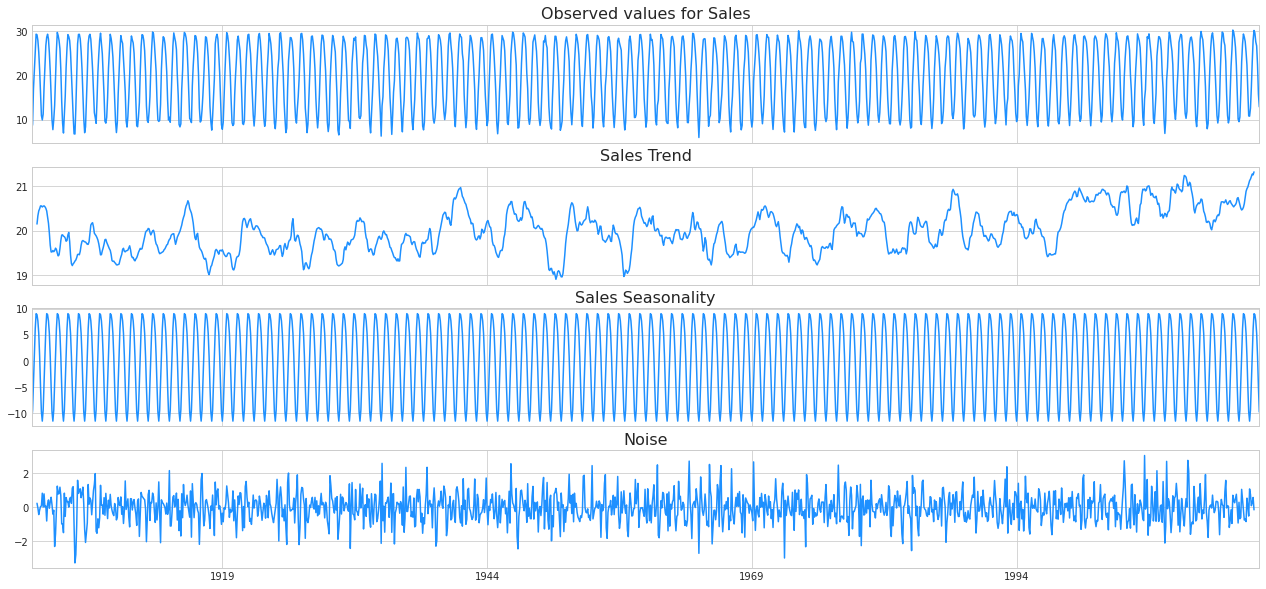

In [15]:
#decomposition
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(tmp['temp'],period=12,model='additive')
fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(22,10))
ax[0].set_title('Observed values for Sales', fontsize=16)
decomp.observed.plot(ax = ax[0], legend=False, color='dodgerblue')
ax[1].set_title('Sales Trend', fontsize=16)
decomp.trend.plot(ax = ax[1],legend=False, color='dodgerblue')

ax[2].set_title('Sales Seasonality', fontsize=16)
decomp.seasonal.plot(ax = ax[2],legend=False, color='dodgerblue')

ax[3].set_title('Noise', fontsize=16)
decomp.resid.plot(ax = ax[3],legend=False, color='dodgerblue')

In [16]:
#adf test
from statsmodels.tsa.stattools import adfuller
p_value_adfuller = adfuller(tmp['temp'])[1]
print(p_value_adfuller)

0.0029944496012250894


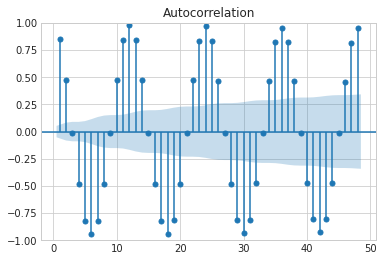

In [17]:
plot_acf(tmp['temp'].dropna(), lags=48, zero=False);

The series has an interesting behavior, there is a sequential significative negative autocorrelation starting at lag 6 and repeating each 12 months, it's because of the difference in the seasons, if today is winter with cold temperatures in 6 months we will have higher temperatures in the summer, that's why the negative autocorrelation occurs. These temperatures usually walk in opposite directions.

In [18]:
tmp['diff_temp']=tmp['temp'].diff(1)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


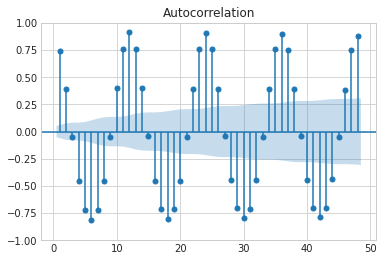

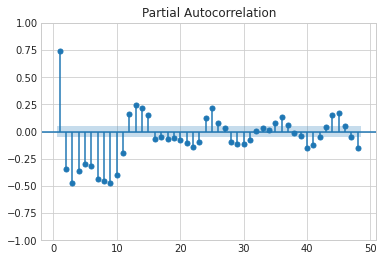

In [19]:
#plot acf and pacf of diff
plot_acf(tmp['diff_temp'].dropna(), lags=48, zero=False);
plot_pacf(tmp['diff_temp'].dropna(), lags=48, zero=False);

PACF shows a positive spike in the first lag and a drop to negative PACF in the following lags.

This behavior between the ACF and PACF plots suggests an AR(1) model and also a first seasonal difference ( Yt−Yt−12 ). I'll plot the stationarity function again with the first seasonal difference to see if we will need some SAR(P) or SMA(Q) parameter:

In [20]:
from statsmodels.tsa.arima.model import ARIMA

model_arima =ARIMA(tmp['temp'], order=(2,1,2))
result = model_arima.fit(method_kwargs={"warn_convergence": False})

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [21]:
#mean squared error
from sklearn.metrics import mean_squared_error
predictions = result.predict(start=0, end=len(tmp['temp'])-1, dynamic=False)
mean_squared_error(tmp['temp'], predictions)


2.0749960594862578

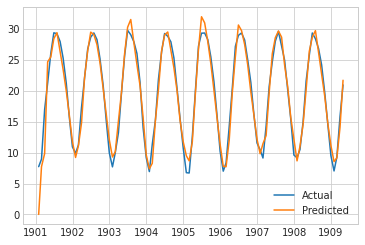

In [22]:
#plot predictions with actual values
plt.plot(tmp['temp'][:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.legend()


In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   temp   No. Observations:                 1392
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2459.309
Date:                Sun, 22 May 2022   AIC                           4928.619
Time:                        04:48:50   BIC                           4954.808
Sample:                    01-31-1901   HQIC                          4938.412
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7206      0.003    496.165      0.000       1.714       1.727
ar.L2         -0.9886      0.003   -300.637      0.000      -0.995      -0.982
ma.L1         -1.8191      0.013   -140.153      0.000      -1.845      -1.794
ma.L2          0.8757      0.013     69.504      0.000       0.851       0.900
sigma2         1.9980      0.075     26.731      0.000       1.852       2.145
===================================================================================
Ljung-Box (L1) (Q):                   5.58   Jarque-Bera (JB):                12.68
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.20
Prob(H) (two-sided):                  0.92   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

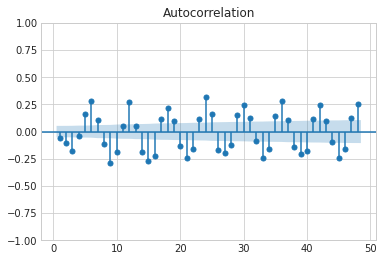

In [24]:
#plot residuals acf
plot_acf(result.resid, lags=48, zero=False);

In [25]:
tmp['diff_temp']=tmp['temp'].diff(12)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


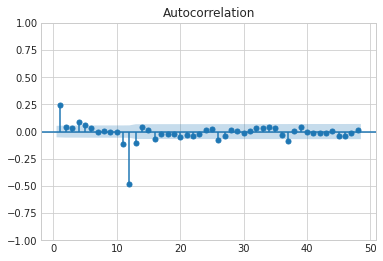

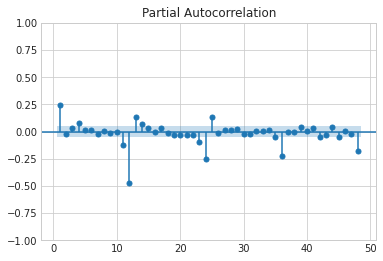

In [26]:
#plot acf and pacf of diff
plot_acf(tmp['diff_temp'].dropna(), lags=48, zero=False);
plot_pacf(tmp['diff_temp'].dropna(), lags=48, zero=False);

In [27]:
#sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(tmp['temp'], order=(2,1,2), seasonal_order=(0,1,1,12))
result_sarimax = model_sarimax.fit(disp=False)


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [28]:
#mean squared error
from sklearn.metrics import mean_squared_error
predictions_sarimax = result_sarimax.predict(start=0, end=len(tmp['temp'])-1, dynamic=False)
mean_squared_error(tmp['temp'], predictions_sarimax)

1.0972861955649005

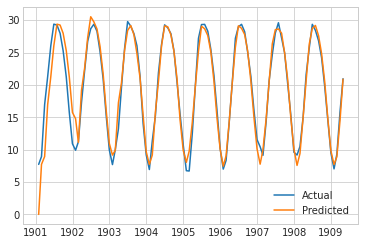

In [29]:
#plot predictions with actual values
plt.plot(tmp['temp'][:100], label='Actual')
plt.plot(predictions_sarimax[:100], label='Predicted')
plt.legend()

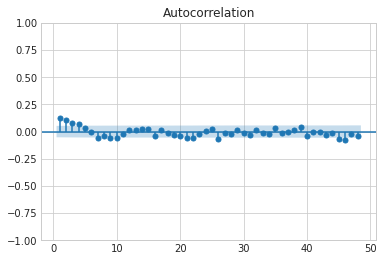

In [30]:
#plot residuals acf
plot_acf(result_sarimax.resid, lags=48, zero=False);


In [31]:
result_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 temp   No. Observations:                 1392
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1886.297
Date:                              Sun, 22 May 2022   AIC                           3784.593
Time:                                      04:49:01   BIC                           3815.968
Sample:                                  01-31-1901   HQIC                          3796.330
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6145      0.481     -1.278      0.201      -1.557       0.328
ar.L2          0.2286      0.112      2.034      0.042       0.008       0.449
ma.L1         -0.1213      0.482     -0.252      0.801      -1.066       0.824
ma.L2         -0.8586      0.476     -1.802      0.072      -1.793       0.075
ma.S.L12      -0.9627      0.009   -103.297      0.000      -0.981      -0.944
sigma2         0.8781      0.028     31.585      0.000       0.824       0.933
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                58.75
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
%%time
#auto arima model
from pmdarima import auto_arima
model_auto_arima = auto_arima(tmp['temp'], max_p=4, max_q=4, m=12, start_p=1, max_Q=4,max_P=4, trace=True, error_action='ignore', suppress_warnings=True,maxiter=10)

Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=5076.332, Time=2.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9516.851, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=7016.708, Time=1.49 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12470.766, Time=0.03 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=6109.354, Time=1.55 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=4685.307, Time=2.00 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=6515.959, Time=0.57 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=6135.253, Time=4.93 sec
 ARIMA(1,0,2)(2,0,1)[12] intercept   : AIC=4849.903, Time=4.04 sec
 ARIMA(0,0,2)(1,0,0)[12] intercept   : AIC=10898.846, Time=0.91 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=5453.058, Time=3.11 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=8479.358, Time=2.29 sec
 ARIMA(1,0,3)(1,0,0)[12] intercept   : AIC=4881.488, Time=2.17 sec
 ARIMA(0,0,1)(1,0,0)[1

In [33]:
#mean squared error
predictions_auto_arima = model_auto_arima.predict(n_periods=len(tmp['temp']))
mean_squared_error(tmp['temp'], predictions_auto_arima)


28.86020418037563

In [34]:
#ARIMA(2,0,1)(4,0,0)[12]  
arima_model2=ARIMA(tmp['temp'], order=(2,0,1), seasonal_order=(4,0,0,12))
arima_results2=arima_model2.fit()


/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


LinAlgError: LU decomposition error.

In [ ]:
#mean squared error
from sklearn.metrics import mean_squared_error
predictions_arima2 = arima_results2.predict(start=0, end=len(tmp['temp'])-1, dynamic=False)
mean_squared_error(tmp['temp'], predictions_arima2)


In [14]:

def create_timeseries_dataset(X,y,timestep=1):
    Xs,ys=list(),list()
    for i in range(len(X)-timestep):
        v=X[i:(i+timestep)]
        Xs.append(v)
        ys.append(y[i+timestep])
    return np.array(Xs),np.array(ys)

In [23]:
X,y=create_timeseries_dataset(tmp['temp'],tmp['temp'],timestep=12)

In [25]:
import tensorflow as tf
#convert to tensorflow dataset
X_train,y_train=X[:int(0.8*len(X))],y[:int(0.8*len(X))]
X_test,y_test=X[int(0.8*len(X)):],y[int(0.8*len(X)):]
train_data=tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(1)
test_data=tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(1)

2022-05-24 09:19:07.920748: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-24 09:19:07.920777: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-05-24 09:19:11.997031: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-24 09:19:11.997071: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-24 09:19:11.997140: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2022-05-24 09:19:12.001358: I tensorflow/core/platform/cpu_feature_gu

In [30]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape=(12,1)))
model.add(tf.keras.layers.LSTM(units=12, return_sequences=True))
#dense
model.add(tf.keras.layers.Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mse'])
model.fit(train_data, epochs=20, batch_size=1, verbose=2,validation_data=test_data)

Epoch 1/20
1104/1104 - 9s - loss: 212.2249 - mse: 212.2245 - val_loss: 101.1524 - val_mse: 101.1524 - 9s/epoch - 8ms/step
Epoch 2/20
1104/1104 - 6s - loss: 69.2791 - mse: 69.2791 - val_loss: 51.4034 - val_mse: 51.4034 - 6s/epoch - 5ms/step
Epoch 3/20
1104/1104 - 5s - loss: 29.4856 - mse: 29.4856 - val_loss: 18.0793 - val_mse: 18.0793 - 5s/epoch - 4ms/step
Epoch 4/20
1104/1104 - 5s - loss: 12.3337 - mse: 12.3337 - val_loss: 8.9821 - val_mse: 8.9822 - 5s/epoch - 5ms/step
Epoch 5/20
1104/1104 - 5s - loss: 7.5446 - mse: 7.5446 - val_loss: 6.0105 - val_mse: 6.0105 - 5s/epoch - 5ms/step
Epoch 6/20
1104/1104 - 6s - loss: 5.6655 - mse: 5.6655 - val_loss: 4.6901 - val_mse: 4.6901 - 6s/epoch - 5ms/step
Epoch 7/20
1104/1104 - 5s - loss: 4.6964 - mse: 4.6964 - val_loss: 3.9667 - val_mse: 3.9667 - 5s/epoch - 5ms/step
Epoch 8/20
1104/1104 - 5s - loss: 4.0797 - mse: 4.0797 - val_loss: 3.4790 - val_mse: 3.4790 - 5s/epoch - 4ms/step
Epoch 9/20
1104/1104 - 5s - loss: 3.6619 - mse: 3.6619 - val_loss: 3.1

In [32]:
predictions=model.predict(X_test)
predictions=predictions[:,-1]


9/9 [==============================] - 0s 3ms/step


In [33]:
predictions.shape

(276, 1)

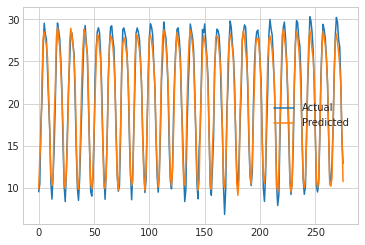

In [36]:
#plot predictions with actual values
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend()